In [1]:
from pylab import *
%matplotlib inline
caffe_root = './'  # this file should be run from {caffe_root} (otherwise change this line)
import sys
sys.path.insert(0, caffe_root + 'python')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import caffe
import numpy as np

In [3]:
# define solver
solver_config_path=caffe_root+'models/ResNet-18/ULQ/resnet18-ulq2_solver-pycaffe.prototxt'
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()
s.random_seed = 0xCAFFE
# load model prototxt
s.net = "models/ResNet-18/ULQ/resnet18_ulq2.prototxt"
# s.net="../caffe/models/ResNet-18/train.prototxt"
# s.test_net.append(test_net_path)
s.test_interval = 1000  # Test after every 1000 training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.
s.max_iter = 55000   # no. of times to update the net (training iterations)
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "SGD"
# s.type="Adam"
# Set the initial learning rate for SGD.
s.base_lr = 0.001  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 0
# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'multistep'
s.stepvalue.append(30000)
s.stepvalue.append(45000)
s.stepvalue.append(50000)
s.gamma = 0.1
# s.power=1
s.test_initialization=False
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'
# Display the current training loss and accuracy every 1000 iterations.
s.display = 100
# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 5000
s.snapshot_prefix = "models/ResNet-18/ULQ/model/resnet-18_ulq2"
# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU
# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

In [4]:
# If you have the pretraining weights
weights="../caffe/models/ResNet-18/ULQ/model/resnet-18_ulq2.caffemodel"
### load the solver and create train and test nets
# caffe.set_device(0)#set your own gpu id
caffe.set_mode_gpu()
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)
# solver=caffe.get_solver("models/ResNet-18/ULQ/resnet18_ulq2_solver.prototxt")
solver.net.copy_from(weights)
solver.test_nets[0].copy_from(weights)

In [86]:
training_batch_size=64
iter_size=4
training_samples=1280000
train_iterations=int(training_samples/training_batch_size)
# train_iterations=10
test_batch_size=50
test_samples=50000
test_iterations=int(test_samples/test_batch_size)
# test_iterations=10
print "Training iterations=", train_iterations, ", Test iterations=",test_iterations
def evaluate(solver, test_iterations):
    correct1=0
    correct5=0
    loss=0
    for test_it in range(test_iterations):
        print "\rTest %.2f%%"%((test_it+1.0)*100/test_iterations),
        solver.test_nets[0].forward()
#         correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)== solver.test_nets[0].blobs['label'].data)
        correct1+=solver.test_nets[0].blobs['acc/top-1'].data
        correct5+=solver.test_nets[0].blobs['acc/top-5'].data
        loss+=solver.test_nets[0].blobs['loss'].data
    correct1 = correct1 / test_iterations
    correct5 = correct5 / test_iterations
    loss=loss/test_epoch
    print(" loss=%.4f, test Top 1 accuracy=%.4f, Top 5 accuracy=%.4f"%(loss,correct1,correct5))
    return loss,correct1,correct5
def fit(solver,epoches,train_iterations):
    # the main solver loop
    history={"top1":[],"top5":[],"loss":[]}
    for ep in range(epoches):
        for train_it in range(train_iterations):
            print "\rEpoch %d: Training %.2f%%"%(ep,(train_it+1.0)*100/train_iterations),
            solver.step(1)
#         solver.step(int(train_iterations))  # run one epoch
        solver.test_nets[0].forward()
        history["top1"].append(float(solver.test_nets[0].blobs['acc/top-1'].data))
        history["top5"].append(float(solver.test_nets[0].blobs['acc/top-5'].data))
        history["loss"].append(float(solver.test_nets[0].blobs['loss'].data))
        print(" loss=%.4f, test Top 1 accuracy=%.4f, Top 5 accuracy=%.4f"%(history["loss"][ep],history["top1"][ep],history["top5"][ep]))
    return history

Training iterations= 20000 , Test iterations= 1000


In [83]:
his=fit(solver,epoches=10,train_iterations=train_iterations)

Epoch 0: Training 100.00%  loss=1.6505, test Top 1 accuracy=0.5800, Top 5 accuracy=0.7600
Epoch 1: Training 100.00%  loss=1.2609, test Top 1 accuracy=0.6000, Top 5 accuracy=0.9200
Epoch 2: Training 100.00%  loss=1.4065, test Top 1 accuracy=0.7000, Top 5 accuracy=0.8400
Epoch 3: Training 100.00%  loss=1.2101, test Top 1 accuracy=0.7200, Top 5 accuracy=0.9400
Epoch 4: Training 100.00%  loss=1.7304, test Top 1 accuracy=0.6600, Top 5 accuracy=0.8600
Epoch 5: Training 100.00%  loss=1.5374, test Top 1 accuracy=0.6000, Top 5 accuracy=0.8800
Epoch 6: Training 100.00%  loss=0.8420, test Top 1 accuracy=0.7400, Top 5 accuracy=0.9400
Epoch 7: Training 100.00%  loss=1.4797, test Top 1 accuracy=0.6800, Top 5 accuracy=0.8600
Epoch 8: Training 100.00%  loss=1.2261, test Top 1 accuracy=0.6400, Top 5 accuracy=0.9000
Epoch 9: Training 100.00%  loss=1.3313, test Top 1 accuracy=0.6600, Top 5 accuracy=0.8600


In [84]:
loss,top1,top5=evaluate(solver,test_iterations)

Test 100.00%  loss=14.3659, test Top 1 accuracy=0.6800, Top 5 accuracy=0.8700


Text(0.5,1,'Test Accuracy: 0.87')

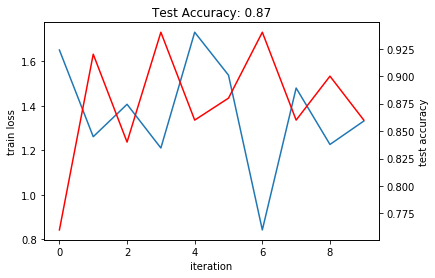

In [85]:
#plot figure
epoches=10
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(epoches), his['loss'])
ax2.plot(arange(epoches), his['top5'], 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(top5))